# Benchmark Brax Rendering Example using JaxRenderer backend

Self-link: https://colab.research.google.com/drive/180T5YOd3HaSILWBSl2nhzRbqMXT8_oO7

Benchmarking using T4 on 32x32 canvas: https://colab.research.google.com/drive/1Z-nH_wn-QZ_BcjlwK32N3GIlh7ZyWAwF

Benchmarking using A100 on micro canvas (84x84): https://colab.research.google.com/drive/1-lToQZ3ZGAVQrnHy39JfneM9iT2HOfaT

Benchmarking using T4 on micro canvas (84x84): https://colab.research.google.com/drive/1Pa5OBHAGmKnuVhvTvgsIhPYJ1WNhdfE6

Benchmarking using T4 on small canvas: https://colab.research.google.com/drive/1X_IbG5SGdQ_GnsjjlBaF9pJQR7vu8Aml

Benchmarking using A100 on small canvas: https://colab.research.google.com/drive/1Mr2pRetdobZdgdtNT_DJuS4YZq3-C4oY

Benchmarking using A100 on larger canvas: https://colab.research.google.com/drive/1A7PzhG3vn6oNzrWTxE5E3dmu8xQTcNnH

Benchmarking using T4, and baseline (CPU PyTinyrenderer): https://colab.research.google.com/drive/1xhkYNz5WjvUCjQWpp72CLf9SIy3i5PnN

Generate data: https://colab.research.google.com/drive/1c_83TLtb_pOt4OSlWFQgIKzA9DxdBDTp

<details>
  <summary>Other related profiling/benchmarking Colabs</summary>

Profile with pre-generated data: https://colab.research.google.com/drive/12yNBVOdwUqUOBRgmQHF0gl8eMzzIi_BH

Previous profile version (profile branch head): https://colab.research.google.com/drive/1V7gdTY6ZYz7YhJI_LCWLZM035zSDTYoQ

Previous prfiling version: https://colab.research.google.com/drive/1BJQG38IHPaUuMKMnNeq0hjrLtqwx4OfU

All-inlines + minibatch loops: https://colab.research.google.com/drive/1NiCTOCxfU0Mvr818Zqt4y63-S20Gn8yb

All-inlines: https://colab.research.google.com/drive/1Wrt3a0yoVPhYUJYCZltFIYoELWD-ciE0

Baseline link: https://colab.research.google.com/drive/17NSjyJL_Ov9D32Mnrs7miZmjiPNf9U6l

</details>

The sample output is using A100 backend, with High RAM (only configuration available).

In [ ]:
#@title Reinstall jaxrenderer from tag `v0.3.0`; Install pytinyrenderer
!pip uninstall jaxrenderer -y -qqq
!pip install git+https://github.com/JoeyTeng/jaxrenderer.git@v0.3.0 -qqq

!pip install pytinyrenderer --upgrade -qqq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.3 MB/s eta 0:00:00


In [ ]:
#@title ## GPU Spec
!nvidia-smi

Tue Jun 20 20:50:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title ## Imports
#@markdown **⚠️ PLEASE NOTE:**

#@markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

from functools import partial
from typing import Optional
import os
import pickle

import jax
from jax import numpy as jp
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
from scipy.spatial.transform import Rotation as R

from tqdm.auto import tqdm

import pytinyrenderer

from renderer import CameraParameters as Camera
from renderer import LightParameters as Light
from renderer import ModelObject as Instance
from renderer import ShadowParameters as Shadow
from renderer import Renderer, transpose_for_display

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

In [ ]:
#@title ## Load data; Constants
!rm inputs-30.zip >/dev/null 2>&1
!rm inputs.pickle >/dev/null 2>&1
!wget -q https://github.com/JoeyTeng/jaxrenderer/raw/92904b74f4d760cd66b8940ed41c2d854cfbebe9/test_resources/pre-gen-brax/inputs-30.zip -O inputs-30.zip
!unzip -q inputs-30.zip

FRAMES_AVAILABLE: int = 30

_batched_instances, _batched_camera, _batched_target = pickle.load(open("inputs.pickle", "rb"))

canvas_width: int = 32 #@param {type:"integer"}
canvas_height: int = 32 #@param {type:"integer"}

_batched_instances = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_instances)
_batched_camera = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_camera)
_batched_target = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_target)

In [ ]:
#@title ## Utility Function
import gc
import itertools
import time
from typing import Any, Callable


def benchmark(
    f: Callable[[], Any],
    repeat: int = 2,
    number: int = 1,
    sort: bool = True,
) -> list[int]:
  """Execute given pure function `f` `number` times and take sum, repeat for
    `repeat` times.

  In total, f is executed repeat * number times.

  This function is a very similar re-implementation of `timeit.repeat`.

  Parameters:
    - f: Pure function to be tested, taking no parameter and returns nothing.
      Return value is ignored. This function must be safe to reentrancy.
    - repeat: int, default 2.
    - number: int, default 1.
    - sort: bool, default True. Whether to sort result timings (in ascending
      order)

  Return:
    a list of total execution times, in nanoseconds. The size of the results
    equals to `repeat`.
  """
  result: list[int] = []

  for _ in range(repeat):
    it = itertools.repeat(None, number)
    gcold = gc.isenabled()
    gc.disable()

    try:
      _t_before: int = time.perf_counter_ns()
      for _ in it:
        f()
      _t_after: int = time.perf_counter_ns()
    finally:
      if gcold:
        gc.enable()

    result.append(_t_after - _t_before)

  if sort:
    result.sort()

  return result


def plot(seriesA: pd.Series, seriesB: pd.Series, title: str, ylabel: str, xlabel: str = "num frames"):
  fig, ax = plt.subplots()
  ax.plot(seriesA, label=seriesA.name, color="#39C5BB")
  ax.plot(seriesB, label=seriesB.name, color="#FFA500")
  ax.grid()
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  fig.legend()

## Experiment - JaxRenderer

In [ ]:
#@title ### Render function
def profile_compile(batched_instances, batched_camera, batched_target, loop_unroll: int = 1):
  """Return cost analysis. states is batched."""
  @jax.default_matmul_precision("float32")
  def render_instances(
    instances: list[Instance],
    width: int,
    height: int,
    camera: Camera,
    light: Optional[Light] = None,
    shadow: Optional[Shadow] = None,
    camera_target: Optional[jp.ndarray] = None,
    enable_shadow: bool = True,
  ) -> jp.ndarray:
    """Renders an RGB array of sequence of instances.

    Rendered result is not transposed with `transpose_for_display`; it is in
    floating numbers in [0, 1], not `uint8` in [0, 255].
    """
    if light is None:
      direction = jp.array([0.57735, -0.57735, 0.57735])
      light = Light(
          direction=direction,
          ambient=0.8,
          diffuse=0.8,
          specular=0.6,
      )
    if shadow is None and enable_shadow:
      assert camera_target is not None, 'camera_target is None'
      shadow = Shadow(centre=camera_target)
    elif not enable_shadow:
      shadow = None

    img = Renderer.get_camera_image(
      objects=instances,
      light=light,
      camera=camera,
      width=width,
      height=height,
      shadow_param=shadow,
      loop_unroll=loop_unroll,
    )
    arr = jax.lax.clamp(0., img, 1.)

    return arr

  def _render(instances, camera, target) -> jp.ndarray:
    _render = jax.jit(
      render_instances,
      static_argnames=("width", "height", "enable_shadow"),
      inline=True,
    )
    img = _render(instances=instances, width=canvas_width, height=canvas_height, camera=camera, camera_target=target)
    arr = transpose_for_display((img * 255).astype(jp.uint8))

    return arr

  _render_batch = jax.jit(jax.vmap(jax.jit(_render, inline=True)))
  _render_batch_lowered = _render_batch.lower(batched_instances, batched_camera, batched_target)
  _render_batch_compiled = _render_batch_lowered.compile()

  return _render_batch_compiled

### Branchless + loop unroll

In [ ]:
#@title loop unroll options
loop_unroll_cases: list[int] = [1, 2, 4, 16, 32]

In [ ]:
#@title benchmarking

# render 30 frames per batch
batched_instances = _batched_instances
batched_camera = _batched_camera
batched_target = _batched_target

timings = onp.zeros((len(loop_unroll_cases), 4), dtype=int)
column_indices = ["compilation (min)", "compilation (max)", "execution (min)", "execution (max)"]
row_indices = loop_unroll_cases.copy()

for i, loop_unroll in tqdm(enumerate(loop_unroll_cases), total=len(loop_unroll_cases)):
  ts = benchmark(lambda: profile_compile(batched_instances, batched_camera, batched_target, loop_unroll=loop_unroll))
  # only take the minimum/maximum time
  timings[i, 0] = ts[0]
  timings[i, 1] = ts[-1]

  _render_batch_compiled = profile_compile(batched_instances, batched_camera, batched_target, loop_unroll=loop_unroll)

  ts = benchmark(lambda: _render_batch_compiled(batched_instances, batched_camera, batched_target).block_until_ready(), repeat=7)
  # only take the minimum/maximum time
  timings[i, 2] = ts[0]
  timings[i, 3] = ts[-1]

  0%|          | 0/5 [00:00<?, ?it/s]

,compilation (min),compilation (max),execution (min),execution (max)
1,4591535697,7079722127,18430849,72340806
2,5247689490,6339468517,17880603,33648810
4,6503508479,7813696826,16806136,35171449
16,13456538773,15273314648,15690421,21767699
32,26194227789,28750634311,15588963,73603822


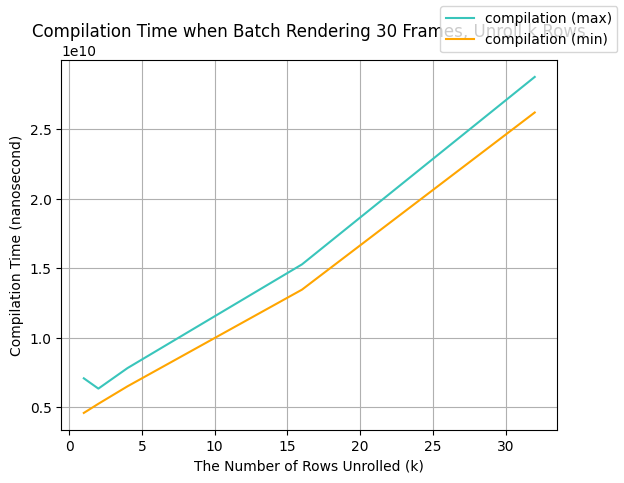

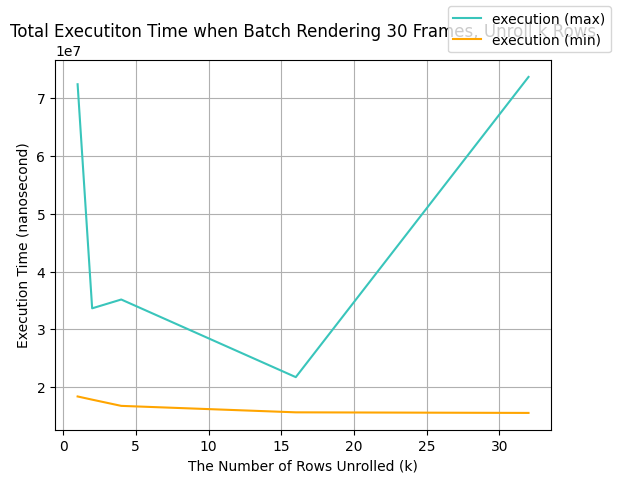

In [ ]:
df_unroll = pd.DataFrame(timings, index=row_indices, columns=column_indices)
display(df_unroll)

plot(
    df_unroll[column_indices[1]],
    df_unroll[column_indices[0]],
    title="Compilation Time when Batch Rendering 30 Frames, Unroll k Rows",
    ylabel="Compilation Time (nanosecond)",
    xlabel="The Number of Rows Unrolled (k)"
)

plot(
    df_unroll[column_indices[3]],
    df_unroll[column_indices[2]],
    title="Total Executiton Time when Batch Rendering 30 Frames, Unroll k Rows",
    ylabel="Execution Time (nanosecond)",
    xlabel="The Number of Rows Unrolled (k)"
)

,max fps,min fps
1,1627.705810,414.703701
2,1677.795766,891.561990
4,1785.062313,852.964574
16,1911.994586,1378.188848
32,1924.438463,407.587530


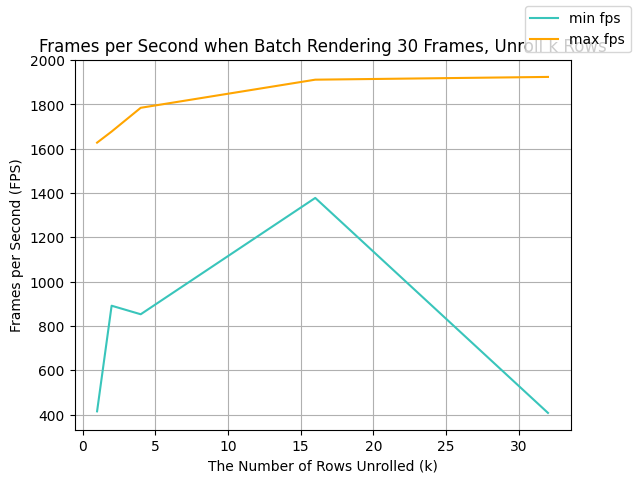

In [ ]:
df_unroll_fps = pd.DataFrame(1 / (timings[:, 2:] / 10**9 / FRAMES_AVAILABLE), index=loop_unroll_cases, columns=("max fps", "min fps"))
display(df_unroll_fps)

plot(
    df_unroll_fps["min fps"],
    df_unroll_fps["max fps"],
    title="Frames per Second when Batch Rendering 30 Frames, Unroll k Rows",
    ylabel="Frames per Second (FPS)",
    xlabel="The Number of Rows Unrolled (k)"
)


### Unroll = 32, number of frames

  0%|          | 0/23 [00:00<?, ?it/s]

,execution (min),execution (max)
1,3947112,18549619
2,4755794,14463392
3,5058685,15077525
4,5331039,15381356
5,5401087,14438182
6,5638330,15018696
7,6059617,191534693
8,6177170,15730808
9,6457409,15573884
10,7057238,245899440


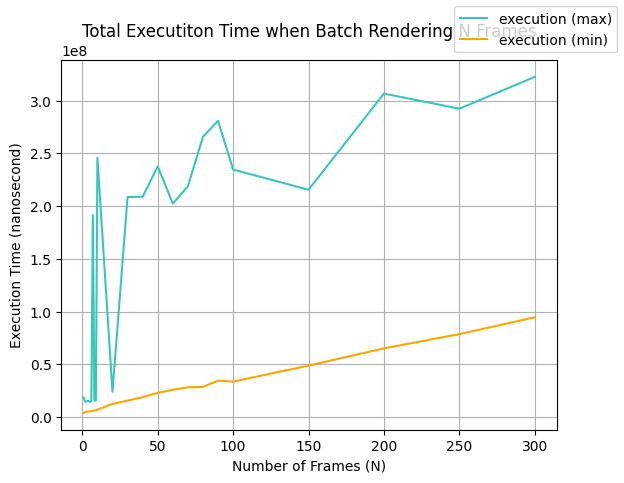

In [ ]:
#@title Benchmarking
loop_unroll: int = 32
num_frames = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300]
frames_per_batch = FRAMES_AVAILABLE

num_frames_timings = onp.zeros((len(num_frames), 2), dtype=int)
column_indices = ["execution (min)", "execution (max)"]
row_indices = num_frames.copy()

batched_instances = _batched_instances
batched_camera = _batched_camera
batched_target = _batched_target


for i, num_frame in tqdm(enumerate(num_frames), total=len(num_frames)):
  # prepare data
  def prepare_data(param):
    batched = jax.tree_map(
        lambda field: jax.lax.concatenate(
            [field] * (num_frame // field.shape[0]) + [field[:(num_frame % field.shape[0])]],
            0,
        ).block_until_ready(),
        param,
    )

    return batched

  batched_instances = prepare_data(_batched_instances)
  batched_camera = prepare_data(_batched_camera)
  batched_target = prepare_data(_batched_target)

  # benchmark
  _render_batch_compiled = profile_compile(batched_instances, batched_camera, batched_target, loop_unroll=loop_unroll)
  times = num_frame // frames_per_batch
  ts = benchmark(lambda: _render_batch_compiled(batched_instances, batched_camera, batched_target).block_until_ready(), repeat=7)

  # only take the minimum/maximum time
  num_frames_timings[i, 0] = ts[0]
  num_frames_timings[i, 1] = ts[-1]


df_time = pd.DataFrame(num_frames_timings, index=row_indices, columns=column_indices)
display(df_time)

plot(
    df_time[column_indices[1]],
    df_time[column_indices[0]],
    title="Total Executiton Time when Batch Rendering N Frames",
    ylabel="Execution Time (nanosecond)",
    xlabel="Number of Frames (N)"
)

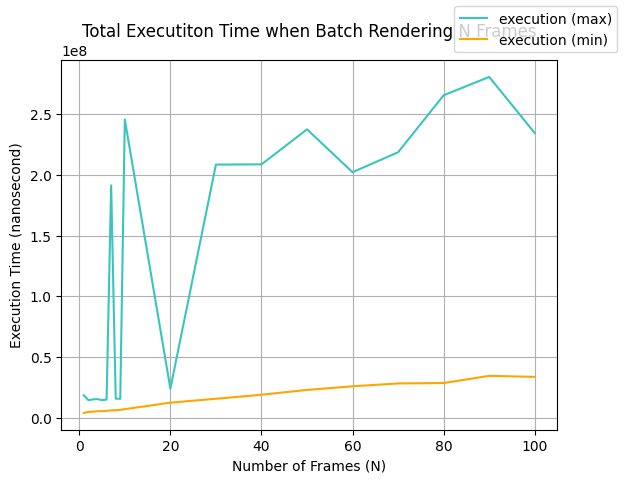

In [ ]:
plot(
    df_time[column_indices[1]].head(19),
    df_time[column_indices[0]].head(19),
    title="Total Executiton Time when Batch Rendering N Frames",
    ylabel="Execution Time (nanosecond)",
    xlabel="Number of Frames (N)"
)

,max fps,min fps
1,253.349791,53.909463
2,420.539662,138.280149
3,593.039495,198.971648
4,750.322779,260.055095
5,925.739578,346.303988
6,1064.144880,399.502061
7,1155.188521,36.546904
8,1295.091442,508.556204
9,1393.747864,577.890525
10,1416.984945,40.667030


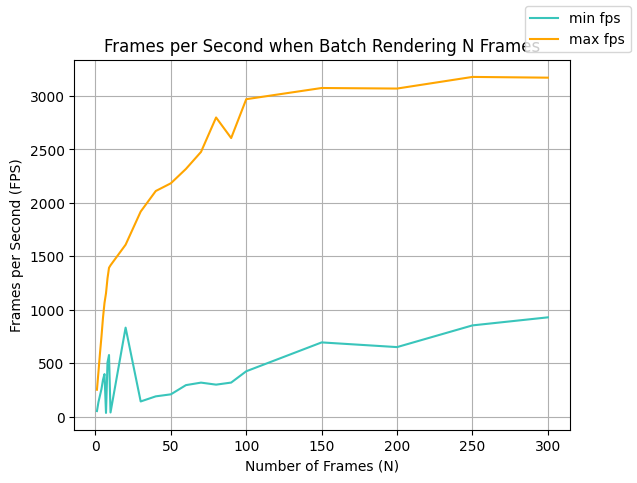

In [ ]:
df_fps = pd.DataFrame(1 / (num_frames_timings / 10**9 / onp.array(num_frames)[:, None]), index=row_indices, columns=("max fps", "min fps"))
display(df_fps)

plot(
    df_fps['min fps'],
    df_fps['max fps'],
    title="Frames per Second when Batch Rendering N Frames",
    ylabel="Frames per Second (FPS)",
    xlabel="Number of Frames (N)",
)

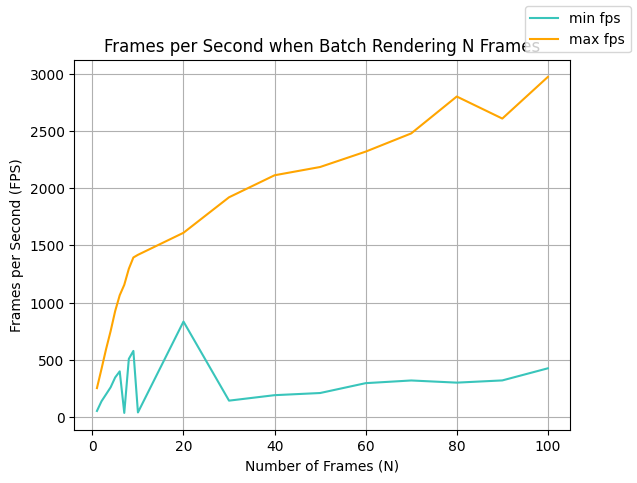

In [ ]:
plot(
    df_fps['min fps'].head(19),
    df_fps['max fps'].head(19),
    title="Frames per Second when Batch Rendering N Frames",
    ylabel="Frames per Second (FPS)",
    xlabel="Number of Frames (N)",
)

In [ ]:
#@title # Terminating Colab Automatically
try:
  from google.colab import runtime
  print("Terminating Colab")
  runtime.unassign()
except ModuleNotFoundError:
  print("Not in Colab, skip termination")